# ETEX-I experiment
This notebook illustrates how to use BiasCorrGP with LS-APC model for the source term for the inversion on the ETEX-I dataset.

In [1]:
import numpy as np
import torch
import h5py
from IPython.display import display, Markdown

from src.biascorrgp.models import TripleGP_prior, TripleGP_posterior, lsapc_sourceTerm
from src.biascorrgp.data_handling.load_data import load_input_data, prepare_inversion_data
from src.biascorrgp.data_handling.training import create_training_data, normalized_lengthscales_same
from src.biascorrgp.utils.plotting import multi_L_curve, plot_source, plot_scatter_linear, plot_scatter_log, plot_predicted_shifts, concentration_plot_etex
from src.biascorrgp.utils.predict import prediction_data, predict_shifts

In [2]:
#load the data and prepare it for the inversion
inp_data = load_input_data("data/ETEX/input_etex_data.h5", xtrue=True) #contains measurements, SRS matrices, locations of the measurements...
inv_data = prepare_inversion_data(inp_data) #contains measurements, SRS matrices and their differences needed for inversion

#create the training data - normalized locations and their mutual distances
train_X, lon_lat_scaler, time_scaler = create_training_data(inp_data)

In [3]:
#define the lengthscales for the GPs
real_space_lengthscale = 1.0 #best solution for ETEX
outputscale = 0.009 #best solution for ETEX
normed_l = normalized_lengthscales_same(real_space_lengthscale, lon_lat_scaler, time_scaler) #lengthscales scaled to normalized coordinates

#define the GP prior for bias correction
bc_prior = TripleGP_prior(train_X, normed_l, outputscale)

#define the GP posterior for bias correction
bc_posterior = TripleGP_posterior(inv_data.Dh, inv_data.Dv, inv_data.Dt, inv_data.M, sh = 0.5, sv = 0.5, st = 3.0) #create posterior with shift means initialized to zeros

#create the source term 
source = lsapc_sourceTerm(inv_data.M, gamma = 1, omega_opt=True) #precision omega is optimized together with the source term

## Inversion
Firstly, the inversion is illustrated for the set of parameters chosen as the best ones. 

In [4]:
#optimization loop
iter = 300
mse = [] #stores MSe values during the optimization
max_shift = [] #stores maximal shift during the optimization
oms = [] #stores omega values during the optimization - for convergence checking
totem = [] #stores the sum of the source term during the optimization - for convergence checking
with torch.no_grad():
    for it in range(iter):
        #inversion
        tildeM = bc_posterior.get_tildeM() #returns only inv_data.M for it < 50
        tildeMttildeM = bc_posterior.get_tildeMttildeM(tildeM) #returns only inv_data.M.T @ inv_data.M for it < 50

        source.optimization_step(tildeM, tildeMttildeM, inv_data.y) #update parameters of the source model
        hat_z = source.hat_x.clone() #first mometn of the source term
        hat_zz = source.hat_xxt.clone() #second moment of the source term

        #bias correction step - it is turned on after 50 steps of inevrsion only
        if it > 50: 
            bc_posterior.optimization_step(hat_z, hat_zz, inv_data.y, source.hat_omega.item(), bc_prior) #update parameters of the posterior of the shifts

        #save and print current state
        if it % 10 == 0:
            tildeM = bc_posterior.get_tildeM()
            pred = tildeM @ hat_z
            mse.append(inv_data.coef**2*torch.mean((inv_data.y - pred)**2).detach())
            oms.append(source.hat_omega.item())
            max_shift.append(torch.max(torch.abs(bc_posterior.mu_h)))
            totem.append(source.hat_x.sum())
            print(f"Iteration {it}/{iter}, max h shift = {torch.max(torch.abs(bc_posterior.mu_h)):.3f}, MSE = {mse[-1]:.3f}, omega = {source.hat_omega.item():.3f}")


Iteration 0/300, max h shift = 0.000, MSE = 0.117, omega = 1346.528
Iteration 10/300, max h shift = 0.000, MSE = 0.177, omega = 889.475
Iteration 20/300, max h shift = 0.000, MSE = 0.175, omega = 896.737
Iteration 30/300, max h shift = 0.000, MSE = 0.175, omega = 898.877
Iteration 40/300, max h shift = 0.000, MSE = 0.175, omega = 900.261
Iteration 50/300, max h shift = 0.000, MSE = 0.174, omega = 901.431
Iteration 60/300, max h shift = 0.716, MSE = 0.064, omega = 2459.284
Iteration 70/300, max h shift = 0.782, MSE = 0.062, omega = 2526.406
Iteration 80/300, max h shift = 0.695, MSE = 0.062, omega = 2524.453
Iteration 90/300, max h shift = 0.697, MSE = 0.062, omega = 2519.607
Iteration 100/300, max h shift = 0.697, MSE = 0.062, omega = 2518.975
Iteration 110/300, max h shift = 0.697, MSE = 0.062, omega = 2518.839
Iteration 120/300, max h shift = 0.697, MSE = 0.062, omega = 2518.794
Iteration 130/300, max h shift = 0.697, MSE = 0.062, omega = 2518.772
Iteration 140/300, max h shift = 0.6

### Multi-L-curve plot

When inversion is performed for a grid of length-scale and output-scale values, we can create a multi-L-curve plot. Here, we will upload only the neecessary statistics of the runs so that the repository does not contain all the data, but it can be simply created by running the inversion for all the pairs of length-scale and output-scale values and saving the resulting MSE and maximal absolute shift values.

In [5]:
with h5py.File("results/ETEX/l_curve_data.h5", "r") as f:
        ls = f["lengthscales"][:]
        ss = f["outputscales"][:]
        maxhs = f["max_shift"][:]
        mses = f["mse"][:]

### This plot shows the multi-L-curve plot for the provided grid of length-scale and output-scale values.

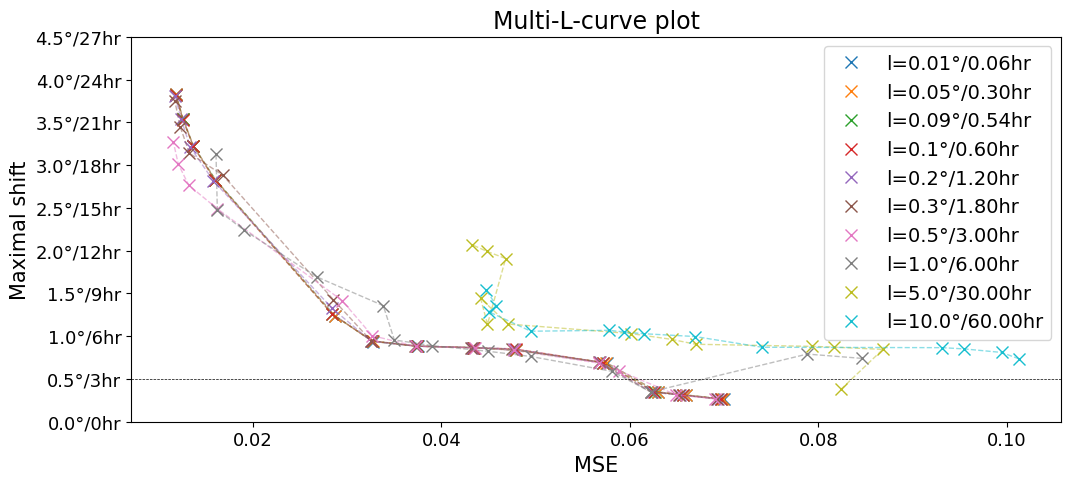

In [6]:
multi_L_curve(ls, ss, mses, maxhs, "etex")
display(Markdown(f"### This plot shows the multi-L-curve plot for the provided grid of length-scale and output-scale values."))

Given the multi-L-curve plot, the user can choose the candidate points and analyze them. Lets' say that we choose l=1.0°/6.00hr and $\sigma=0.009$. This solution was found in the above inversion or can be uploaded from 'results/etex/results_l1_s0009.h5'.

In [4]:
#you can load the solution using this code cell

with h5py.File("results/ETEX/results_l1_s0009.h5", "r") as f: 
    z = f["source"][:]
    hh = f["hh"][:]
    hv = f["hv"][:]
    ht = f["ht"][:]

bc_posterior.mu_h = torch.tensor(hh, dtype = torch.float64).reshape(-1)
bc_posterior.mu_v = torch.tensor(hv, dtype = torch.float64).reshape(-1)
bc_posterior.mu_t = torch.tensor(ht, dtype = torch.float64).reshape(-1)
source.hat_x = torch.tensor(z, dtype = torch.float64).reshape(-1)

### This plot shows the time profile of the source term.

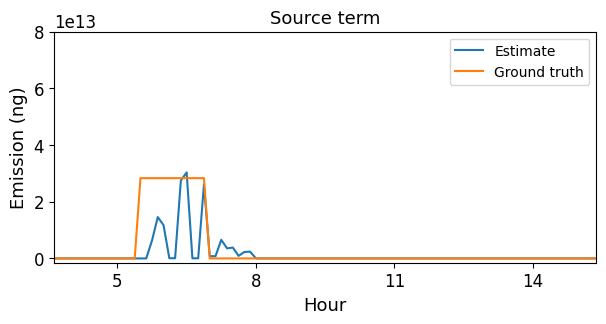

In [5]:
plot_source(source.hat_x, "etex", inp_data.x_true)
display(Markdown(f"### This plot shows the time profile of the source term."))

### This plot shows the linear-scale scatter plot of the predicted concentrations vs measurements. It also includes the $R^2$ and final MSE.

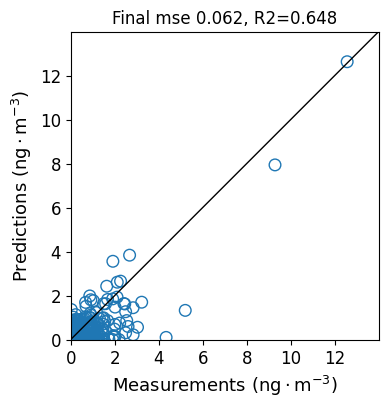

In [12]:
y_pred = bc_posterior.predict_y(source.hat_x, sc = inv_data.coef)
plot_scatter_linear(inp_data.y, y_pred, "etex")
display(Markdown(fr"### This plot shows the linear-scale scatter plot of the predicted concentrations vs measurements. It also includes the $R^2$ and final MSE."))

### This plot shows the logarithmic-scale scatter plot of the predicted concentrations vs measurements with values smaller than $10^-8$ set to this value.

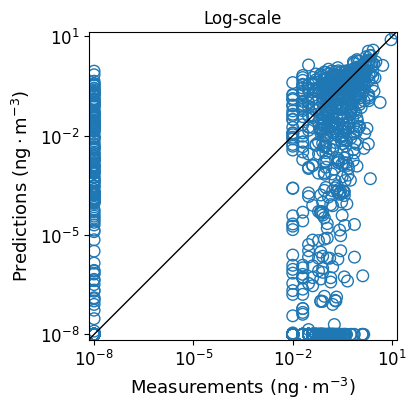

In [7]:
plot_scatter_log(inp_data.y, y_pred, "etex")
display(Markdown(fr"### This plot shows the logarithmic-scale scatter plot of the predicted concentrations vs measurements with values smaller than $10^{-8}$ set to this value."))

## Prediction of shifts in new locations
The GP prior allows us to predict shifts in any space-time location inside the studied domain. Lets' predict them for time interval T+12 - T+13. Spatial domain for prediction is 5°W-15°E in longitude and 45°N-55°N in latitude.

41 steps in logintude
21 steps in latitude


### This plot shows the predicted shifts of the concentration field in time step T+12 - T+13.

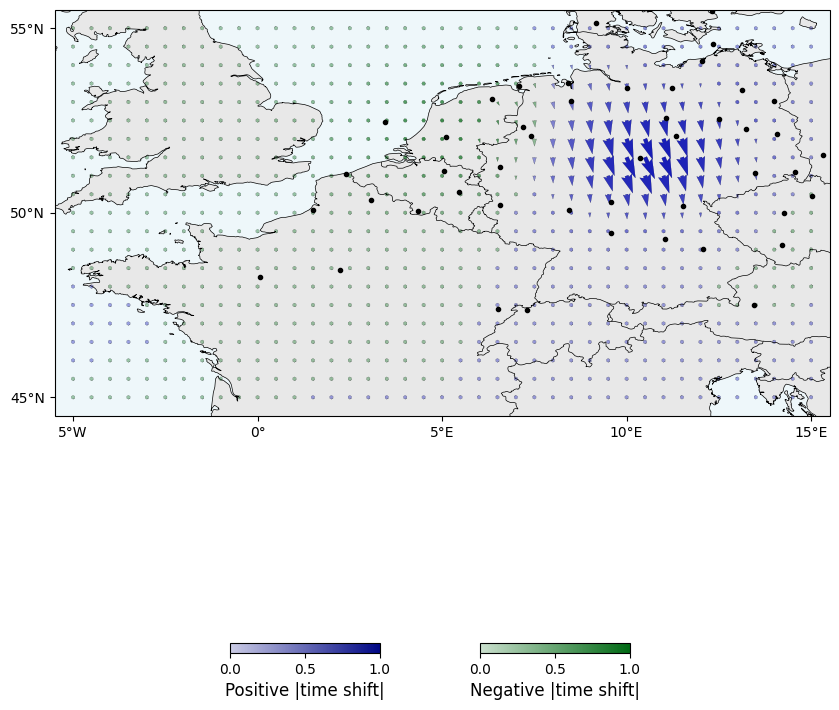

In [6]:
scale = 4 #scale parameter for better visibility of arrows

lon_min = -5
lon_max = 15
lat_min = 45
lat_max = 55
time_ints = np.array([[11, 12], [12,13], [13, 14]]).reshape((3,2)) #the time input includes time neighbourhood of interval <11,12> and <13, 14> for more accurate prediction
xstar, x_star_normed = prediction_data(lon_min, lat_min, lon_max, lat_max, time_ints, lon_lat_scaler, time_scaler) 
hs_pred = predict_shifts(bc_prior, bc_posterior, train_X, x_star_normed, same_lengthscale=False)
plot_predicted_shifts(inp_data, np.array([12,13]), lon_min, lon_max, lat_min, lat_max, xstar, hs_pred, (bc_posterior.shvt[2]*bc_posterior.mu_t).detach().numpy(), scale)
display(Markdown(fr"### This plot shows the predicted shifts of the concentration field in time step T+12 - T+13."))

If the SRS coefficients are available for the whole grid, it is posible to predict the whole concentration field. We will again perform this for the time interval T+12 - T+13. We consider the whole domain as 5°W-30°E in longitude nad 40°N-65°N in latitude. 

In [7]:
lon_min = -5
lat_min = 40
lon_max = 30
lat_max = 65
time_ints = np.array([[11, 12], [12,13], [13, 14]]).reshape((3,2)) #the time input includes time neighbourhood of interval <11,12> and <13, 14> for more accurate prediction
xstar_full, x_star_normed_full = prediction_data(lon_min, lat_min, lon_max, lat_max, time_ints, lon_lat_scaler, time_scaler) 
hs_pred_full = predict_shifts(bc_prior, bc_posterior, train_X, x_star_normed_full, same_lengthscale=False)

71 steps in logintude
51 steps in latitude


In [8]:
with h5py.File("data/ETEX/whole_domain_srs.h5", "r") as f: #load the srs matrices
    M = f["M"][:]
    Ms = f["Ms"][:]
    Mn = f["Mn"][:]
    Mw = f["Mw"][:]
    Me = f["Me"][:]
    Mtm = f["Mtm"][:]
    Mtp = f["Mtp"][:]

#compute differences
D_lon = (Me-Mw)/2
D_lat = (Ms-Mn)/2
D_time = (Mtm-Mtp)/2

In [9]:
hs_pred_12 = hs_pred_full[:, xstar_full[:, 2] == 12].T #extract the corresponding time interval from predicted shifts
xstar_12 = xstar_full[xstar_full[:,2] == 12] #extract the corresponding time interval from coordinates
lons = xstar_12[:,0].reshape(71,51) #reshape to grid
lats = xstar_12[:,1].reshape(71,51) #reshape to grid
hh12 = hs_pred_12[:,0].reshape(71,51)[1:-1, 1:-1].T.numpy() #reshape the shifts to grid
hv12 = hs_pred_12[:,1].reshape(71,51)[1:-1, 1:-1].T.numpy() #reshape the shifts to grid
ht12 = hs_pred_12[:,2].reshape(71,51)[1:-1, 1:-1].T.numpy() #reshape the shifts to grid

In [13]:
z = source.hat_x.detach().numpy().squeeze() #extract the stimated source term to compute the predicted concentrations

y_res = np.zeros((49,69)) #buffer for the grid of concentrations
for k in range(142): #for each step of the source term
    Mc = M[:, :, k] #uncorrected SRS matrix
    tildeM = M[:,:,k] + hh12*D_lat[:,:,k] + hv12*D_lon[:,:,k] + ht12*D_time[:,:,k] #corrected SRS matrix
    y_res += tildeM * z[k] #add the concentration produced by k-th time step to the total prediction 

y_res[y_res <0] = 0

### This plot shows the predicted concentration in time step T+12 - T+13.

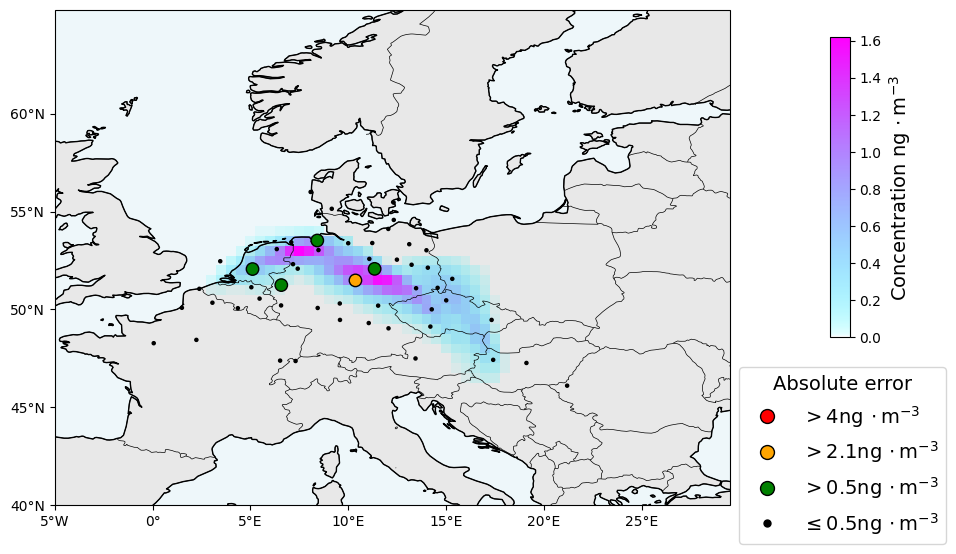

In [15]:
concentration_plot_etex(inp_data, y_res, np.array([12,13]), y_pred.numpy(), lat_min, lat_max, lon_min, lon_max)
display(Markdown(fr"### This plot shows the predicted concentration in time step T+12 - T+13."))